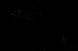

In [1]:
from PIL import Image

from repath.utils.paths import project_root

Image.open(project_root() / 'experiments' / 'cervical_256' / 'patch256_results' / 'valid' / 'heatmaps' / 'IC-CX-00068-01_malignant.png')

In [2]:
import pandas as pd

res_root = project_root() / 'experiments' / 'cervical_256' / 'patch_results' / 'train'
res_ind = pd.read_csv(res_root / 'results_index.csv')
res_ind

,slide_idx,csv_path,png_path,level,patch_size
0,150,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
1,148,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
2,144,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
3,141,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
4,138,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
...,...,...,...,...,...
97,8,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
98,6,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
99,4,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256
100,2,/home/ubuntu/repath/experiments/cervical_256/p...,/home/ubuntu/repath/experiments/cervical_256/p...,0,256


In [3]:
from skimage.measure import label, regionprops

from repath.postprocess.instance_segmentors import ConnectedComponents
    

def calculate_slide_features(heatmap, tissue_area, suffix) -> pd.DataFrame:
    def get_global_features(img_grey: np.array, labelled_image: np.ndarray, tissue_area: int):
        """ Create features based on whole slide properties of a given trheshold

        Args:
            img_grey: a greyscale heatmap where each pixel represents a patch. pixel values from 0, 255
                with 255 representing a probability of one
            thresh: the threshold probability to use to bbinarize the image
            tiss_area: the area of the image that is tissue in pixels

        Returns:
            A tuple containing:
                area_ratio - the ratio of number of pixels over the given probability to the tissue area
                prob_area - the sum of probability of all the pixels over the threshold divided by the tissue area
        """

        # measure connected components
        reg_props_t = regionprops(labelled_image)
        # get area for each region
        img_areas = [reg.area for reg in reg_props_t]
        # get total area of tumor regions
        metastatic_area = np.sum(img_areas)
        # get area ratio
        area_ratio = metastatic_area / tissue_area

        # get list of regions
        labels_t = np.unique(labelled_image)
        # create empty list of same size
        lab_list_t = np.zeros((len(labels_t), 1))
        # for each region
        for lab in range(1, len(labels_t)):
            # get a mask of just that region
            mask = labelled_image == lab
            # sum the probability over the region in the mask
            tot_prob = np.sum(np.divide(img_grey[mask], 255))
            # add to empty list
            lab_list_t[lab, 0] = tot_prob
        # sum over whole list
        tot_prob_t = np.sum(lab_list_t)
        # diveide by tissue area
        prob_area = tot_prob_t / tissue_area

        return area_ratio, prob_area

    def get_region_features(reg) -> list:
        """ Get list of properties of a ragion

        Args:
            reg: a region from regionprops function

        Returns:
            A list of 11 region properties

        """
        # get area of region
        reg_area = reg.area
        # eccentricity - for an ellipse with same second moments as region
        # divide distance between focal points by length of major axis
        reg_eccent = reg.eccentricity
        # extent ratio of pixels in region to pixels in bounding box
        reg_extent = reg.extent
        # area of bounding box of region
        reg_bbox_area = reg.bbox_area
        # major axis length of ellipse with same second moment of area
        reg_maj_ax_len = reg.major_axis_length
        # highest probabaility in the region
        reg_max_int = reg.max_intensity
        # mean probability voer he region
        reg_mean_int = reg.mean_intensity
        # lowest probability in the region
        reg_min_int = reg.min_intensity
        # Rrtio of pixels in the region to pixels of the convex hull image.
        reg_solid = reg.solidity
        # cacluate aspect ration of region bounding box
        reg_bbox = reg.bbox
        reg_aratio = (reg_bbox[2] - reg_bbox[0]) / (reg_bbox[3] - reg_bbox[1])

        output_list = [reg_area, reg_eccent, reg_extent, reg_bbox_area, reg_maj_ax_len, reg_max_int,
                    reg_mean_int, reg_min_int, reg_aratio, reg_solid]
        return output_list


    assert heatmap.dtype == 'float' and np.max(heatmap) <= 1.0 and np.min(heatmap) >= 0.0, "Heatmap in wrong format"

    # set thresholds for global features
    threshz = [0.5, 0.6, 0.7, 0.8, 0.9]

    # create storage for global features as an 1xn array. There are two features for each threshold.
    glob_list = np.zeros((1, 2 * len(threshz)))
    # for each threshold calculate two features and store in array
    for idx, th in enumerate(threshz):
        segmentor = ConnectedComponents(th)
        labelled_image = segmentor.segment(heatmap)
        outvals = get_global_features(heatmap, labelled_image, tissue_area)
        glob_list[0, (idx * 2)] = outvals[0]
        glob_list[0, (idx * 2 + 1)] = outvals[1]

    # get two largest areas at 0.5 thresh
    segmentor = ConnectedComponents(0.5)
    labelled_image = segmentor.segment(heatmap)

    # measure connected components
    reg_props_5 = regionprops(labelled_image, intensity_image=heatmap)

    # get area for each region
    img_areas_5 = [reg.area for reg in reg_props_5]

    # get labels for each region
    img_label_5 = [reg.label for reg in reg_props_5]

    # sort in descending order
    toplabels = [x for _, x in sorted(zip(img_areas_5, img_label_5), reverse=True)][0:2]

    # create empty 1x20 array to store ten feature values each for top 2 lesions
    loc_list = np.zeros((1, 20))

    # per lesion add to store - labels start from 1 need to subtract 1 for zero indexing
    for rg in range(2):
        if len(img_areas_5) > rg:
            reg = reg_props_5[toplabels[rg] - 1]
            outvals = get_region_features(reg)
        else:
            outvals = [0] * 10
        loc_list[0, (rg * 10):((rg + 1) * 10)] = outvals

    # combine global features and lesion features into one array
    features_list = np.hstack((glob_list, loc_list))

    # create column names
    out_cols = ["area_ratio_5", "prob_score_5", "area_ratio_6", "prob_score_6", "area_ratio_7", "prob_score_7",
                "area_ratio_8", "prob_score_8", "area_ratio_9", "prob_score_9",
                "area_1", "eccentricity_1", "extent_1", "bbox_area_1", "major_axis_1", "max_intensity_1",
                "mean_intensity_1", "min_intensity_1", "aspect_ratio_1", "solidity_1",
                "area_2", "eccentricity_2", "extent_2", "bbox_area_2", "major_axis_2", "max_intensity_2",
                "mean_intensity_2", "min_intensity_2", "aspect_ratio_2", "solidity_2"]
    out_cols = [cl + suffix for cl in out_cols]

    # convert to dataframe with column names
    features_df = pd.DataFrame(features_list, columns=out_cols)
    #features_df['slidename'] = slide_path
    #features_df['slide_label'] = result.label.lower()
    #features_df['tags'] = result.tags

    return features_df

In [4]:
from pathlib import Path

import numpy as np

malig_threshold = 0.9

for idx, csvpath in enumerate(res_ind.csv_path):
    results = pd.read_csv(csvpath)
    tissue_area = results.shape[0]
    
    malig_hm_path = res_root / 'heatmaps' / (Path(csvpath).stem + '_malignant.png')
    malig_hm = np.asarray(Image.open(malig_hm_path)) / 255
    features_ml = calculate_slide_features(malig_hm, tissue_area, "_ML")
    highg_hm_path = res_root / 'heatmaps' / (Path(csvpath).stem + '_high_grade.png')
    highg_hm = np.asarray(Image.open(highg_hm_path)) / 255
    features_hg = calculate_slide_features(highg_hm, tissue_area, "_HG")
    lowg_hm_path = res_root / 'heatmaps' / (Path(csvpath).stem + '_low_grade.png')
    lowg_hm = np.asarray(Image.open(lowg_hm_path)) / 255
    features_lg = calculate_slide_features(lowg_hm, tissue_area, "_LG")
    
    features_df = pd.concat((features_ml, features_hg, features_lg), axis=1)
    features_df['slidename'] = Path(csvpath).stem
    
    if idx == 0:
        slide_features = features_df
    else:
        slide_features = pd.concat((slide_features, features_df))


In [5]:
import repath.data.datasets.cervical_debug as cervical

dset = cervical.debug()
dset.paths

,slide,annotation,label,tags
0,iCAIRD/IC-CX-00001-01.isyntax,iCAIRD_annotations/batch1/IC-CX-00001-01.tiff.txt,normal_inflammation,normal_inflammation;train
1,iCAIRD/IC-CX-00002-01.isyntax,iCAIRD_annotations/batch1/IC-CX-00002-01.tiff.txt,malignant,other;train
2,iCAIRD/IC-CX-00003-01.isyntax,iCAIRD_annotations/batch1/IC-CX-00003-01.tiff.txt,high_grade,cin2;train
3,iCAIRD/IC-CX-00004-01.isyntax,iCAIRD_annotations/batch1/IC-CX-00004-01.tiff.txt,normal_inflammation,normal_inflammation;train
4,iCAIRD/IC-CX-00005-01.isyntax,iCAIRD_annotations/batch1/IC-CX-00005-01.tiff.txt,malignant,cgin;train
...,...,...,...,...
147,iCAIRD/IC-CX-01485-01.isyntax,iCAIRD_annotations/batch17/IC-CX-01485-01.tiff...,malignant,squamous_carcinoma;valid
148,iCAIRD/IC-CX-01782-01.isyntax,iCAIRD_annotations/batch21/IC-CX-01782-01.tiff...,malignant,other;train
149,iCAIRD/IC-CX-01825-01.isyntax,iCAIRD_annotations/batch21/IC-CX-01825-01.tiff...,malignant,other;train
150,iCAIRD/IC-CX-02058-01.isyntax,iCAIRD_annotations/batch24/IC-CX-02058-01.tiff...,malignant,adenocarcinoma;train


In [6]:
slide_labels = [""] * slide_features.shape[0]

for snidx, sn in enumerate(slide_features['slidename']):
    for slidx, sl in enumerate(dset.paths['slide']):
        if sn == Path(sl).stem:            
            label = dset.paths['label'].iloc[slidx]
            slide_labels[snidx] = label


In [7]:
from sklearn.ensemble import RandomForestClassifier

slide_features_no_name = slide_features.drop(columns=['slidename'])
slide_model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
slide_model.fit(slide_features_no_name, slide_labels)

RandomForestClassifier(max_features='sqrt')

In [8]:
val_root = project_root() / 'experiments' / 'cervical_256' / 'patch256_results' / 'valid'
val_ind = pd.read_csv(val_root / 'results_index.csv')

In [9]:
for idx, csvpath in enumerate(val_ind.csv_path):
    results = pd.read_csv(csvpath)
    tissue_area = results.shape[0]
    
    malig_hm_path = val_root / 'heatmaps' / (Path(csvpath).stem + '_malignant.png')
    malig_hm = np.asarray(Image.open(malig_hm_path)) / 255
    features_ml = calculate_slide_features(malig_hm, tissue_area, "_ML")
    highg_hm_path = val_root / 'heatmaps' / (Path(csvpath).stem + '_high_grade.png')
    highg_hm = np.asarray(Image.open(highg_hm_path)) / 255
    features_hg = calculate_slide_features(highg_hm, tissue_area, "_HG")
    lowg_hm_path = val_root / 'heatmaps' / (Path(csvpath).stem + '_low_grade.png')
    lowg_hm = np.asarray(Image.open(lowg_hm_path)) / 255
    features_lg = calculate_slide_features(lowg_hm, tissue_area, "_LG")
    
    features_df = pd.concat((features_ml, features_hg, features_lg), axis=1)
    features_df['slidename'] = Path(csvpath).stem
    
    if idx == 0:
        valid_features = features_df
    else:
        valid_features = pd.concat((valid_features, features_df))


In [10]:
valid_labels = [""] * valid_features.shape[0]

for snidx, sn in enumerate(valid_features['slidename']):
    for slidx, sl in enumerate(dset.paths['slide']):
        if sn == Path(sl).stem:            
            label = dset.paths['label'].iloc[slidx]
            valid_labels[snidx] = label

In [11]:
valid_features_no_name = valid_features.drop(columns=['slidename'])
predictions = slide_model.predict(valid_features_no_name)

In [12]:
from repath.utils.metrics import conf_mat_raw, conf_mat_plot_heatmap

cm_slide = conf_mat_raw(np.array(valid_labels), np.array(predictions), ['normal_inflammation', 'low_grade', 'high_grade', 'malignant'])

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

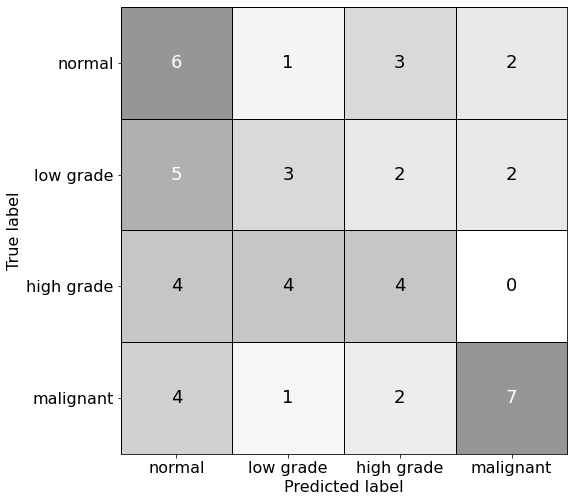

In [13]:
conf_mat_plot_heatmap(cm_slide, ['normal', 'low grade', 'high grade', 'malignant'], "")

In [29]:
from sklearn.neural_network import MLPClassifier

slide_model2 = MLPClassifier(hidden_layer_sizes=[50], max_iter=2000)
slide_model2.fit(slide_features_no_name, slide_labels)

MLPClassifier(hidden_layer_sizes=[50], max_iter=2000)

In [30]:
predictions2 = slide_model2.predict(valid_features_no_name)

In [31]:
cm_slide2 = conf_mat_raw(np.array(valid_labels), np.array(predictions2), ['normal_inflammation', 'low_grade', 'high_grade', 'malignant'])

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

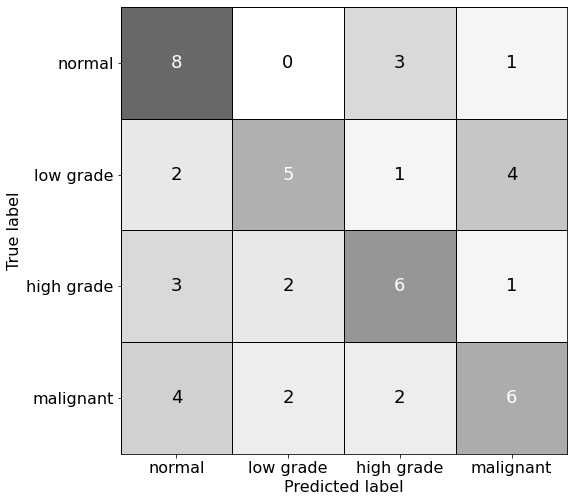

In [32]:
conf_mat_plot_heatmap(cm_slide2, ['normal', 'low grade', 'high grade', 'malignant'], "")